<a href="https://colab.research.google.com/github/teruyo14/Classification-of-CIFAR10-with-Major-CNNs-and-Visualization-with-t-SNE/blob/main/Classification_of_CIFAR10_with_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Papers :Going deeper with convolutions  
https://arxiv.org/pdf/1409.4842.pdf

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import copy

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 48558081.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x, return_embed=False):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        if return_embed:
            return x
        x = self.linear(x)
        return x

    def get_device(self):
        return self.linear.weight.device

    def copy(self):
        return copy.deepcopy(self)

In [ ]:
model = GoogLeNet()
model.to(device)

GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, m

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00009, weight_decay=5e-4)

In [ ]:
def plot_t_sne(data_loader, model,num_samples):
    model.eval()

    # Formatting data for t-SNE
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # Extracting features
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # To Numpy Array
    x = x.numpy()
    y = y.numpy()

    # Extract a specified number of samples
    x = x[:num_samples]
    y = y[:num_samples]

    # Apply t-SNE
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # Set color and marker for each label
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # Plot data
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')

    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.title("Model:GoogLeNet", fontsize = 70, y = -0.1)
    plt.show()

epoch: 1, loss: 1.218575891362347, acc: 0.5595409274101257,      val loss: 0.8859225772440243, val acc: 0.6893969774246216
epoch: 2, loss: 0.7628716593244789, acc: 0.7357046008110046,      val loss: 0.630663891141407, val acc: 0.7870407104492188
epoch: 3, loss: 0.5973426367675198, acc: 0.7952055335044861,      val loss: 0.5054802579906421, val acc: 0.8240814805030823
epoch: 4, loss: 0.5058797120247144, acc: 0.8261955976486206,      val loss: 0.4737726818924895, val acc: 0.8357627391815186
epoch: 5, loss: 0.4389913098234743, acc: 0.8504878282546997,      val loss: 0.4435965488322627, val acc: 0.8496405482292175
epoch: 6, loss: 0.39087028095947957, acc: 0.8671625256538391,      val loss: 0.38870040305887166, val acc: 0.869408905506134
epoch: 7, loss: 0.35390427251485246, acc: 0.8801783323287964,      val loss: 0.3974153409227015, val acc: 0.8647164106369019
epoch: 8, loss: 0.3268170680085665, acc: 0.8878958821296692,      val loss: 0.3508632113091862, val acc: 0.8819888234138489
epoch: 9

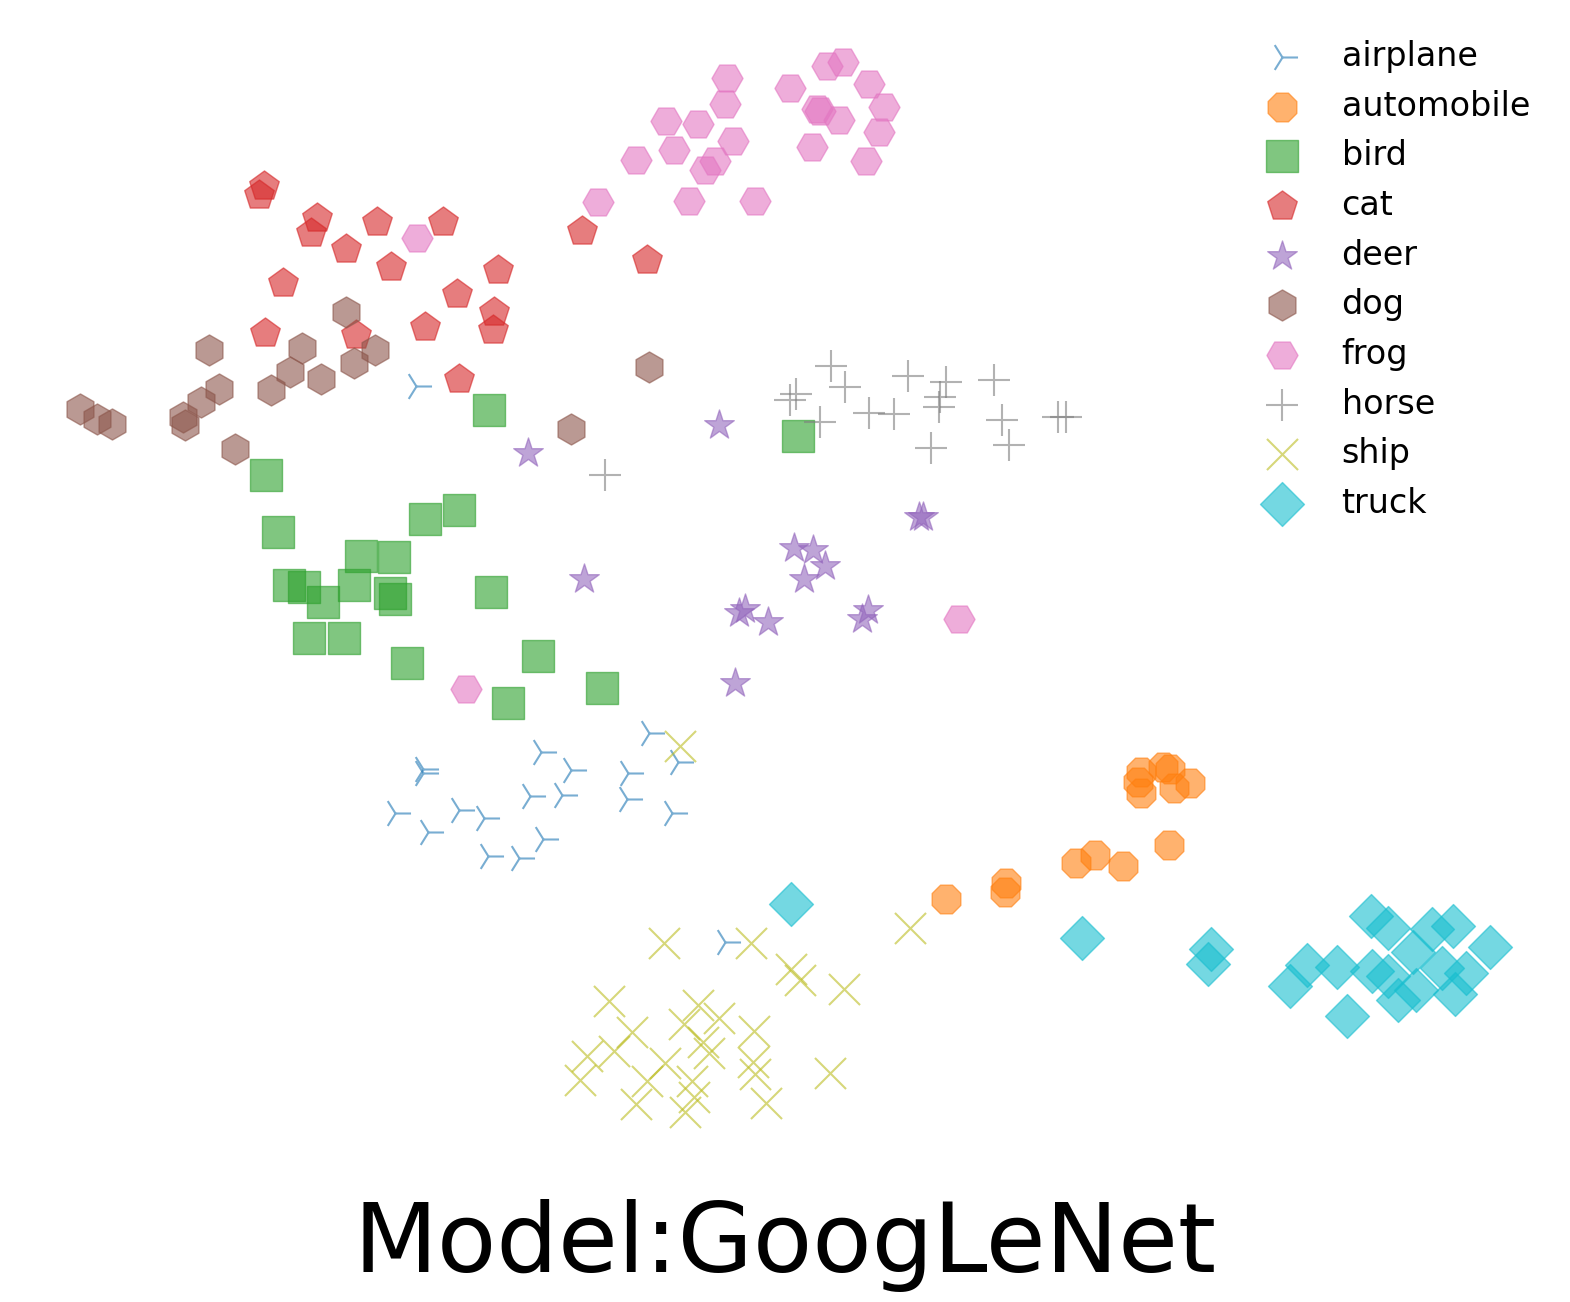

In [ ]:
num_epochs = 20
num_samples = 200
losses = []
accs = []
val_losses = []
val_accs = []
val_acc_best = 0.0
model_best = None
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc.item())
    #
    # validation loop
    #
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc.item())
    if val_running_acc > val_acc_best:
            val_acc_best = val_loss
            model_best = model.copy()
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc))

# Plot distribution of features using t-SNE
plot_t_sne(validation_dataloader, model_best, num_samples)

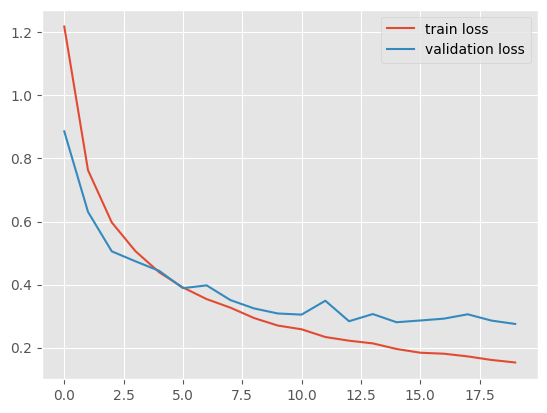

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

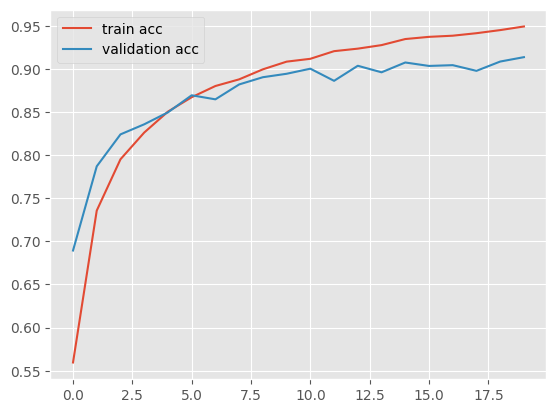

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()